In [1]:
import yt # 
import logging  # Add this import
# Suppress yt logging output
yt.funcs.mylog.setLevel(logging.ERROR)
from numpy.core.fromnumeric import transpose
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
import cmyt
import numpy as np
import pandas as pd
import h5py
from scipy.stats import lognorm
from tqdm import tqdm  # Import tqdm for the progress bar
import time
from collections import namedtuple
from concurrent.futures import ThreadPoolExecutor


from matplotlib import colors
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import copy  # deepcopy sucks！

from collections import OrderedDict

from skimage.measure import profile_line
from scipy.signal import savgol_filter
from scipy import interpolate

from scipy.optimize import curve_fit
from scipy import signal, ndimage
from scipy.signal import savgol_filter

cmpzx = colors.LinearSegmentedColormap.from_list('zx', 
                                             [(0,    '#4747db'),
                                              (1/7, '#00005b'),
                                              (2/7,  '#00ffff'),
                                              (3/7,  '#007f00'),
                                              (4/7,  '#ffff00'),
                                              (5/7,  '#ff6000'),
                                              (6/7,  '#6b0000'),
                                              (7/7,  '#e04c4c'),
                                              ], N=256)

c_cm = ['w', '#4747db', '#00005b', '#00ffff', '#007f00',
        '#ffff00', '#ff6000', '#6b0000', '#e04c4c']
n_cm = [0, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 1]
cmpzx1 = colors.LinearSegmentedColormap.from_list(
    'mycmap', list(zip(n_cm, c_cm)))

In [2]:
def plot_2D_map(plotvar, time_step, vmin=None, vmax=None, cmap="OrRd", log_scale=False, title="Density", 
                figsize=(4, 4), contour=False, levels=None):
    """
    Plot the density map from a 3D array and automatically generate a title based on the time step.
    
    Parameters:
    - plotvar: The 3D array containing the data to plot.
    - time_step: The time step index to select the density data for plotting.
    - vmin, vmax: Minimum and maximum values for color normalization.
    - cmap: Colormap to use for displaying the data.
    - log_scale: Whether to use LogNorm for logarithmic scaling of the colormap.
    - title: Title for the plot.
    - figsize: Tuple specifying the size of the figure in inches (width, height).
    - contour: Whether to overlay contour lines on top of the image plot.
    - levels: The number of contour levels or specific levels to plot (used if contour=True).
    """
    # Determine the normalization based on whether log scale is requested
    if log_scale:
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = None
    
    # Create the figure and axis with the provided figsize and high dpi
    fig, ax = plt.subplots(figsize=(figsize[0]/2.54, figsize[1]/2.54), dpi=300)

    # Plot the density map using the selected time step
    cs = ax.imshow(plotvar[time_step, :, :], origin='lower',
                   extent=[data.xmin, data.xmax, data.ymin, data.ymax],
                   aspect='auto',
                   cmap=cmap,
                   norm=norm)

    # Ensure the aspect ratio of the image remains equal
    ax.set_aspect('equal')

    # Plot contour if requested
    if contour:
        # Generate contours with the specified number of levels (or default to 10 if None)
        if levels is None:
            levels = 10
        ax.contour(plotvar[time_step, :, :], levels=levels, colors='w', linewidths=0.5, extent=[data.xmin, data.xmax, data.ymin, data.ymax])

    # Configure the major and minor ticks for the plot
    ax.tick_params(axis='both', direction='in', labelsize=6, length=4, width=0.3, which='major', top=True, right=True)
    ax.tick_params(axis='both', direction='in', length=2, width=0.3, which='minor', top=True, right=True)

    # Enable minor ticks
    ax.minorticks_on()

    # Set axis labels
    ax.set_xlabel(r'X ($\mathrm{\mu}$m)', fontsize=7, labelpad=1.2)
    ax.set_ylabel(r'Y ($\mathrm{\mu}$m)', fontsize=7, labelpad=1.2)

    # Set axis limits
    ax.set_xlim(-400, 400)
    ax.set_ylim(0, 800)

    # Set the linewidth for the axes
    for spine in ax.spines.values():
        spine.set_linewidth(0.3)

    # Add the colorbar without distorting the image
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Add the colorbar to the plot
    cbar = plt.colorbar(cs, cax=cax, orientation="vertical")

    # Configure the major and minor ticks on the colorbar
    cbar.ax.tick_params(axis='both', which='major', labelsize=5, direction='out', length=2, width=0.25)
    cbar.ax.tick_params(axis='both', which='minor', labelsize=5, direction='out', length=1.5, width=0.2)

    # Set the linewidth for the colorbar outline
    cbar.outline.set_linewidth(0.3)

    # Generate the title automatically based on the time step (assuming each time step is 0.1 ns)
    time_ns = time_step / 10.0
    ax.set_title(f'{title} Map at {time_ns:.1f} ns', fontsize=6)

    return fig, ax


def load_and_process_data(file_dir, file_sub_dir, filename_pattern, lrefine_max=3):
    """
    Load and process a series of datasets from files, generating uniform covering grids 
    and extracting domain information for further analysis.

    Parameters:
    -----------
    file_dir : str
        The base directory where the dataset files are located.
    file_sub_dir : str
        Subdirectory within the base directory containing the dataset files.
    filename_pattern : str
        The filename pattern or wildcard expression to match dataset files (e.g., "radslab_hdf5_plt_cnt_????").
    lrefine_max : int, optional
        The maximum refinement level minus 1, used when creating uniform covering grids.
        For instance, if `lrefine_max=4`, the function uses refinement level 3.
        Default is 3.

    Returns:
    --------
    ProcessedData : namedtuple
        A named tuple containing the following fields:
        - ds_ug : list of numpy arrays
            List of deep-copied uniform covering grids created from the datasets.
        - dx : float
            Grid resolution in the x-direction in micrometers (μm).
        - dy : float
            Grid resolution in the y-direction in micrometers (μm).
        - xmax : float
            Maximum x-coordinate of the domain in micrometers (μm).
        - xmin : float
            Minimum x-coordinate of the domain in micrometers (μm).
        - ymax : float
            Maximum y-coordinate of the domain in micrometers (μm).
        - ymin : float
            Minimum y-coordinate of the domain in micrometers (μm).

    Notes:
    ------
    - The function uses yt to load the dataset series, assumes a valid pattern 
      for the dataset filenames, and processes each dataset to create uniform 
      covering grids with a specified refinement level.
    - The function calculates the grid resolution (dx, dy) and converts domain 
      boundaries from code units to micrometers (μm).
    - The tqdm library is used to provide progress feedback during dataset processing.

    Example Usage:
    --------------
    data = load_and_process_data(
        file_dir="/path/to/data",
        file_sub_dir="simulations",
        filename_pattern="e.g., "radslab_hdf5_plt_cnt_????"",
        lrefine_max=3
    )
    """
    global ts
    # Generate full file path
    file_path = os.path.join(file_dir, file_sub_dir, filename_pattern)
    
    # Load the dataset series
    ts = yt.load(file_path)
    ts = list(ts)
          
    # Precompute shared parameters
    left_edge = ts[0].domain_left_edge
    dims = ts[0].domain_dimensions * 2**lrefine_max
    
    def process_dataset(ds):
        ds.force_periodicity()  # Forces the dataset to assume periodic boundary conditions, overriding non-periodic boundaries to avoid computation errors.
        return ds.smoothed_covering_grid(lrefine_max, left_edge=left_edge, dims=dims)
    
    # Initialize tqdm progress bar
    with ThreadPoolExecutor() as executor:
        with tqdm(total=len(ts), desc="Processing datasets", unit="dataset") as pbar:
            # Wrap the processing function to include progress bar updates
            results = []
            for result in executor.map(process_dataset, ts):
                results.append(result)
                pbar.update(1)  # Update the progress bar for each dataset
            ds_ug = results

    # print("Processing complete!")
        
    # Get domain boundaries and convert to micrometers (um)
    xmax = np.array(ts[0].domain_right_edge.in_units('code_length')[0]) * 1e4
    xmin = np.array(ts[0].domain_left_edge.in_units('code_length')[0]) * 1e4
    ymax = np.array(ts[0].domain_right_edge.in_units('code_length')[1]) * 1e4
    ymin = np.array(ts[0].domain_left_edge.in_units('code_length')[1]) * 1e4
    
    # Calculate grid resolutions in x and y directions
    dx = (xmax - xmin) / ds_ug[0].shape[0]
    dy = (ymax - ymin) / ds_ug[0].shape[1]
    
    # Print the field list
    print("Field List", ts[0].field_list)
    print(f"xRes: {dx:.4f} μm, yRes: {dy:.4f} μm")
    
    ProcessedData = namedtuple('ProcessedData', ['ds_ug', 'dx', 'dy', 'xmax', 'xmin', 'ymax', 'ymin'])
    # Return ProcessedData named tuple
    return ProcessedData(ds_ug=ds_ug, dx=dx, dy=dy, xmax=xmax, xmin=xmin, ymax=ymax, ymin=ymin)

In [3]:
# 定义一个命名元组来存储返回值
# ProcessedData = namedtuple('ProcessedData', ['ds_ug', 'dx', 'dy', 'xmax', 'xmin', 'ymax', 'ymin'])


# Example usage:
# file_dir = '/Volumes/T7 Shield/Postdoc/FLASH_data/SACLA'
# file_sub_dir = '/Volumes/T7 Shield/Postdoc/FLASH_data/SACLA/run23_CH_Prims_nonLTE_3eV_highRes_g20_sinStruc'
# filename_pattern = 'imprint_hdf5_plt_cnt_????'

# '/Users/zhaoxu/Library/CloudStorage/GoogleDrive-xu.zhao@york.ac.uk/.shortcut-targets-by-id/16vAOKRGUkvq0ZGjF5HEk71fTWws4R3BS/Raidaition Drive Ablation Simulation/FLASH/test data'
file_dir = '/Users/zhaoxu/Library/CloudStorage/GoogleDrive-xu.zhao@york.ac.uk/.shortcut-targets-by-id/16vAOKRGUkvq0ZGjF5HEk71fTWws4R3BS/Raidaition Drive Ablation Simulation/'
file_sub_dir = 'FLASH/test data'
filename_pattern = 'radslab_hdf5_plt_cnt_????'

save_path = os.path.join(file_dir, file_sub_dir,"post-processing")
lam = 0.532
nc = (1.115 * 1e21/lam**2)

data = load_and_process_data(file_dir, file_sub_dir, filename_pattern, lrefine_max=3)


Processing datasets: 100%|██████████| 61/61 [00:00<00:00, 3218.31dataset/s]


Field List [('flash', 'dens'), ('flash', 'pres'), ('flash', 'sumy'), ('flash', 'tele'), ('flash', 'tion'), ('flash', 'trad'), ('flash', 'ye')]
xRes: 82.0312 μm, yRes: 46.8750 μm


In [3]:
file_dir = '/Users/zhaoxu/Library/CloudStorage/GoogleDrive-xu.zhao@york.ac.uk/.shortcut-targets-by-id/16vAOKRGUkvq0ZGjF5HEk71fTWws4R3BS/Raidaition Drive Ablation Simulation/'
file_sub_dir = 'FLASH/test data'
filename_pattern = 'radslab_hdf5_plt_cnt_????'

ProcessedData = namedtuple('ProcessedData', ['ds_ug', 'dx', 'dy', 'xmax', 'xmin', 'ymax', 'ymin'])
file_path = os.path.join(file_dir, file_sub_dir, filename_pattern)
lrefine_max = 3
ts = yt.load(file_path)
ts = list(ts)

# Precompute shared parameters
left_edge = ts[0].domain_left_edge
dims = ts[0].domain_dimensions * 2**lrefine_max

def process_dataset(ds):
    ds.force_periodicity()
    return ds.smoothed_covering_grid(lrefine_max, left_edge=left_edge, dims=dims)

# Parallel processing with thread pool
with ThreadPoolExecutor() as executor:
    ds_ug = list(tqdm(executor.map(process_dataset, ts), total=len(ts), desc="Processing datasets", unit="dataset"))
ds_ug


Processing datasets: 100%|██████████| 61/61 [00:00<00:00, 175722.90dataset/s]


[YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0000): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0001): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0002): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0003): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0004): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0005): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0006): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0007): , level=3, left_

In [158]:
ds_ug

[YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0000): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0001): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0002): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0003): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0004): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0005): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0006): , level=3, left_edge=[-3.5    0.    -0.004] cm, ActiveDimensions=[512 256   8],
 YTSmoothedCoveringGrid (radslab_hdf5_plt_cnt_0007): , level=3, left_

In [111]:
ts = yt.load(os.path.join(file_dir, file_sub_dir,filename_pattern))
ds = ts[0]
field = ('flash', 'pres')
ds._get_field_info(field).output_units

ds.domain_left_edge

In [66]:
print(vars(ds))

{'fluid_types': ('gas', 'deposit', 'index', 'flash'), '_handle': <yt.utilities.file_handler.HDF5FileHandler object at 0x36e9f1280>, 'particle_filename': None, '_particle_handle': <yt.utilities.file_handler.HDF5FileHandler object at 0x36e9f1280>, 'refine_by': 2, 'dataset_type': 'flash_hdf5', 'conversion_factors': {}, 'parameters': {'nxb': 32, 'nyb': 32, 'nzb': 1, 'dimensionality': 2, 'globalnumblocks': 30, 'nstep': 1, 'nbegin': 1, 'iprocs': 1, 'jprocs': 1, 'kprocs': 1, 'splitnumblocks': 30, 'splitnumparticles': 0, 'checkpointfilenumber': 0, 'plotfilenumber': 0, 'forcedplotfilenumber': 0, 'time': 0.0, 'dt': 1e-15, 'dtold': 1e-15, 'dtsts': 0.0, 'dtnew': 0.0, 'redshift': 0.0, 'redshiftold': -1.0, 'nextcheckpointtime': 1.0, 'nextplotfiletime': 1e-08, 'nextcheckpointz': 1.7976931348623157e+308, 'nextplotfilez': 0.0, 'corners': 0, 'double_precision': 0, 'geometry': 'cartesian', 'bndpriorityone': 1, 'bndprioritythree': 3, 'bndprioritytwo': 2, 'checkpointfileintervalstep': 1000, 'dr_abortpause'

In [21]:
field = ('flash', 'pres')
unit = ds._get_field_info(field).output_units
unit

'code_mass/(code_length*code_time**2)'

In [134]:
ts = yt.load(os.path.join(file_dir, file_sub_dir,filename_pattern))
ds = ts[1]
ds.force_periodicity()
ds_ug_i = ds.smoothed_covering_grid(3, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions*2**3)
ds_ug_i[("pressure")].to('dyn/cm**2')


unyt_array([[[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            ...,

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [

In [143]:
ds_ug[0][("pressure")].to('dyn/cm**2')

unyt_array([[[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            ...,

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [60295.5078125]],

            [[60295.5078125],
             [60295.5078125],
             [60295.5078125],
             ...,
             [60295.5078125],
             [60295.5078125],
             [

In [23]:
mass_unit = ds.parameters["mass_unit"]
length_unit = ds.parameters["length_unit"]
time_unit = ds.parameters["time_unit"]

# 输出转换因子
print(f"Mass Unit: {mass_unit}")
print(f"Length Unit: {length_unit}")
print(f"Time Unit: {time_unit}")

KeyError: 'mass_unit'

In [50]:
for field in ds.derived_field_list:
    try:
        unit = ds._get_field_info(field).output_units
        print(f"Field: {field}, Unit: {unit}")
    except Exception as e:
        print(f"Field: {field}, Error: {e}")

Field: ('flash', 'cell_volume'), Unit: cm**3
Field: ('flash', 'dens'), Unit: code_mass/code_length**3
Field: ('flash', 'dx'), Unit: cm
Field: ('flash', 'dy'), Unit: cm
Field: ('flash', 'dz'), Unit: cm
Field: ('flash', 'path_element_x'), Unit: cm
Field: ('flash', 'path_element_y'), Unit: cm
Field: ('flash', 'path_element_z'), Unit: cm
Field: ('flash', 'pres'), Unit: code_mass/(code_length*code_time**2)
Field: ('flash', 'sumy'), Unit: 
Field: ('flash', 'tele'), Unit: code_temperature
Field: ('flash', 'tion'), Unit: code_temperature
Field: ('flash', 'trad'), Unit: code_temperature
Field: ('flash', 'volume'), Unit: cm**3
Field: ('flash', 'x'), Unit: cm
Field: ('flash', 'y'), Unit: cm
Field: ('flash', 'ye'), Unit: 
Field: ('flash', 'z'), Unit: cm
Field: ('gas', 'El_number_density'), Unit: cm**(-3)
Field: ('gas', 'averaged_density'), Unit: g/cm**3
Field: ('gas', 'baroclinic_vorticity_magnitude'), Unit: s**(-2)
Field: ('gas', 'baroclinic_vorticity_x'), Unit: s**(-2)
Field: ('gas', 'baroclinic

In [117]:
data.ds_ug[0][("pressure")].to('dyn/cm**2')

RuntimeError: yt attempted to read outside the boundaries of a non-periodic domain along dimension 0.
Region left edge = -3.51640625 code_length, Region right edge = 0.7164062500000002 code_length
Dataset left edge = -3.5 code_length, Dataset right edge = 0.7 code_length

This commonly happens when trying to compute ghost cells up to the domain boundary. Two possible solutions are to select a smaller region that does not border domain edge (see https://yt-project.org/docs/analyzing/objects.html?highlight=region)
or override the periodicity with
ds.force_periodicity()

In [152]:
# Create an empty list to store dens data for all time steps
dens_data = []

# Iterate through all time steps with a progress bar
for ug in tqdm(data.ds_ug, desc="Processing time steps", unit="step"):
    # Extract dens data and convert to code_density units
    dens = np.transpose(np.array(ug[("dens")].to('code_density'))[:, :, 0])
    
    # Add the data to the list
    dens_data.append(dens)

# Convert the list to a numpy array
dens_array = np.array(dens_data)
# Print the shape of the array
print("Shape of dens_array:", dens_array.shape)


Processing time steps:   0%|          | 0/61 [00:00<?, ?step/s]


ReferenceError: weakly-referenced object no longer exists

In [44]:
# Create an empty list to store dens data for all time steps
ne_data = []

# Iterate through all time steps with a progress bar
for ug in tqdm(data.ds_ug, desc="Processing time steps", unit="step"):
    # Extract dens data and convert to code_density units
    ne = np.transpose(np.array(ug[("pressure")].to('dyn/cm**2'))[:, :, 0] )
    
    # Add the data to the list
    ne_data.append(ne)

# Convert the list to a numpy array
ne_array = np.array(ne_data)
# Print the shape of the array
print("Shape of ne_array:", ne_array.shape)

Processing time steps:   0%|          | 0/61 [00:00<?, ?step/s]


RuntimeError: yt attempted to read outside the boundaries of a non-periodic domain along dimension 0.
Region left edge = -3.5 code_length, Region right edge = 0.7000000000000002 code_length
Dataset left edge = -3.5 code_length, Dataset right edge = 0.7 code_length

This commonly happens when trying to compute ghost cells up to the domain boundary. Two possible solutions are to select a smaller region that does not border domain edge (see https://yt-project.org/docs/analyzing/objects.html?highlight=region)
or override the periodicity with
ds.force_periodicity()

(100.0, 180.0)

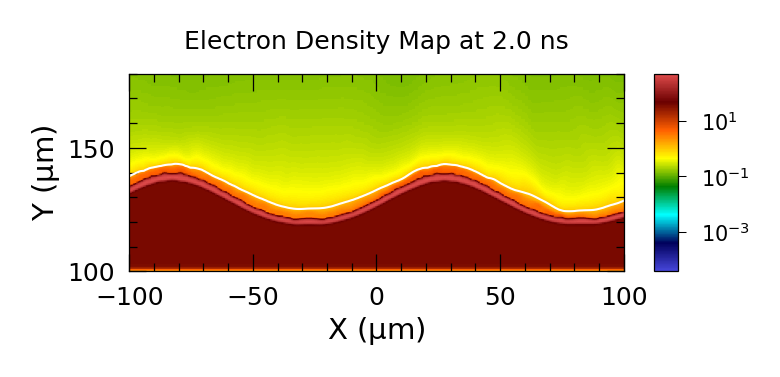

In [15]:
fig, ax1 = plot_2D_map(plotvar=ne_array, time_step=20, log_scale=True, cmap=cmpzx, title="Electron Density", 
                      contour=True, levels=[1] , figsize=(6, 6))

# fig, ax1 = plot_2D_map(plotvar=ne_array,
#                        time_step=30, 
#                        log_scale=True, 
#                        cmap=cmpzx,title="Electron Density",
#                        figsize=(4, 4))

ax1.set_xlim(-100,100)
ax1.set_ylim(100,180)


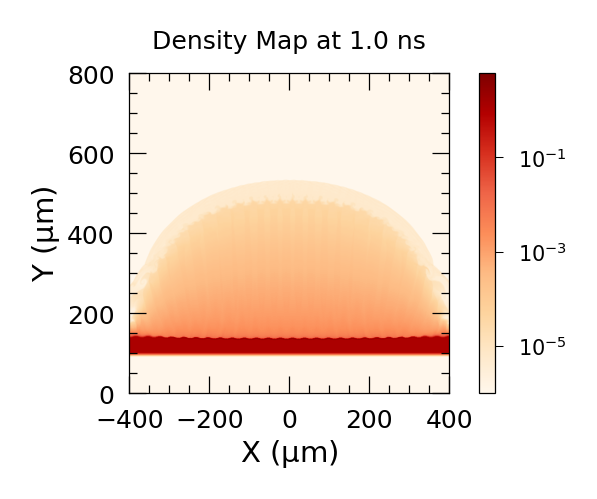

In [12]:
# fig, ax1 = plt.subplots(figsize=(4/2.54, 4/2.54), dpi=300)
fig, ax = plot_2D_map( plotvar=dens_array, time_step=10, log_scale=True, cmap='OrRd',title="Density")

### save data to hdf5

In [13]:
# 使用示例
start_slice = 0
end_slice = 80

save_path = '/Volumes/T7 Shield/Postdoc/FLASH_data/SACLA/run23_CH_Prims_nonLTE_3eV_highRes_g20_sinStruc/post-processing'

# 假设 dens_array 已经定义
save_density_data(dens_array = dens_array, save_path = save_path, start_slice = start_slice, end_slice=end_slice)

Saving data: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]


Data saved to /Volumes/T7 Shield/Postdoc/FLASH_data/SACLA/run23_CH_Prims_nonLTE_3eV_highRes_g20_sinStruc/post-processing/dens_data_0-80.h5


In [9]:
full_path = '/Volumes/T7 Shield/Postdoc/FLASH_data/SACLA/run22_CH_Prims_nonLTE_3eV_highRes_g20/post-processing/dens_data_0-80.h5'
with h5py.File(full_path, 'r') as f:
    # Read the dataset
    dataset = f['density']  # 'density' is the name used when creating the dataset
    
    # Convert the dataset to a NumPy array
    numpy_array = np.array(dataset)

# Now numpy_array is a NumPy array containing all the data
print(numpy_array.shape)
print(numpy_array.dtype)

(80, 1536, 1536)
float64


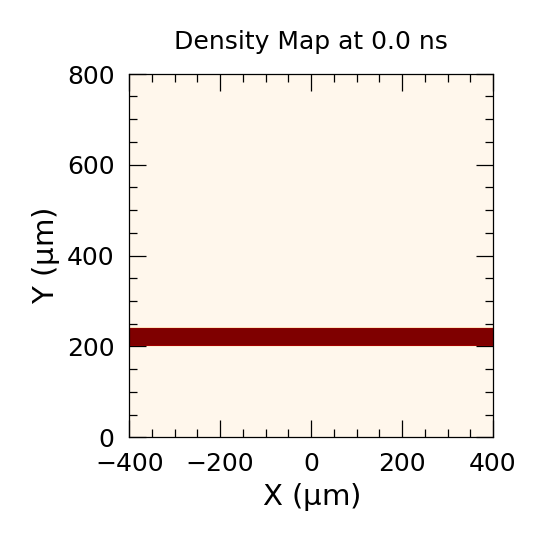

In [191]:
def create_animation(plotvar, cmap, log_scale, title, frames, interval, output_file):
    """
    Creates an animation from the 2D map plot.

    Parameters:
    - plotvar: The 3D data array to be animated.
    - cmap: The colormap to use.
    - log_scale: Whether to use a logarithmic scale for the color map.
    - title: Title of the plot.
    - frames: The number of frames (corresponding to time_steps) in the animation.
    - interval: Time between frames in milliseconds.
    - output_file: Output MP4 file name.
    """
    
    fig, ax1 = plt.subplots(figsize=(4/2.54, 4/2.54), dpi=300)

    def update(time_step):
        plot_2D_map(ax1, plotvar, time_step, cmap=cmap, log_scale=log_scale, title=title)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=frames, interval=interval)
    
    # Save the animation as a GIF file using Pillow
    anim.save(output_file, writer='pillow', fps=1000//interval)

# Example usage
# Assuming 'dens_array' is the 3D array with dimensions (time, x, y) and 'data' is a structure with xmin, xmax, ymin, ymax


create_animation(
    plotvar=dens_array,       # The 3D array
    cmap="OrRd",              # The colormap
    log_scale=False,          # Whether to use logarithmic scaling
    title="Density",          # Title of the plot
    frames=80,                # Number of frames (time steps)
    interval=200,             # Time interval between frames (200ms = 5 FPS)
    output_file="density_animation.gif"  # Output GIF file name
)

In [23]:
# Create an empty list to store dens data for all time steps
depo_data = []

# Iterate through all time steps with a progress bar
for ug in tqdm(data.ds_ug, desc="Processing time steps", unit="step"):
    # Extract dens data and convert to code_density units
    depo = np.transpose(np.array(ug[("depo")])[:, :, 0])
    
    # Add the data to the list
    depo_data.append(depo)

# Convert the list to a numpy array
depo_array = np.array(depo_data)
# Print the shape of the array
print("Shape of dens_array:", depo_array.shape)

Processing time steps: 100%|██████████| 81/81 [00:06<00:00, 12.35step/s]


Shape of dens_array: (81, 1536, 1536)


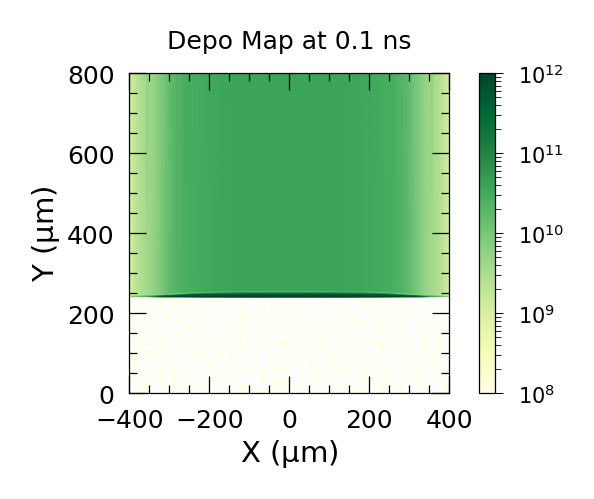

In [70]:
plot_2D_map(plotvar=depo_array, time_step=1,cmap="YlGn",log_scale=True,vmax = 1e12, vmin = 1e8,title="Depo")

The pixel index corresponding to y = 400 is 512


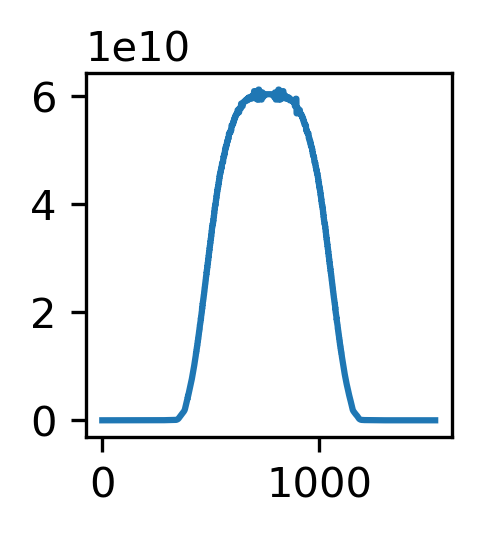

In [110]:
def y_to_pixel(y_value, data, density):
    """
    Converts a given y coordinate (in physical units) to the corresponding pixel index in the density array.
    
    Parameters:
    - y_value: The y coordinate in physical units (e.g., microns).
    - data: A structure that contains ymin and ymax (physical extents of the grid).
    - density: The 3D density array (time, x, y) to determine the number of pixels along the y-axis.
    
    Returns:
    - y_index: The corresponding pixel index for the given y_value.
    """
    
    # Step 1: Determine the number of pixels along the y-axis
    num_y_pixels = density.shape[2]
    
    # Step 2: Calculate the size of each pixel in physical units
    y_pixel_size = (data.ymax - data.ymin) / num_y_pixels
    
    # Step 3: Map the physical y_value to the corresponding pixel index
    y_index = int((y_value - data.ymin) / y_pixel_size)
    
    # Step 4: Ensure the pixel index is within bounds
    y_index = np.clip(y_index, 0, num_y_pixels - 1)
    
    return y_index

# Example usage
y_value = 400  # The y coordinate in physical units
y_index = y_to_pixel(y_value, data, depo_array)
print(f"The pixel index corresponding to y = {y_value} is {y_index}")

time_step = 10
y_intg = 20
y_intg_index = y_to_pixel(y_value, data, depo_array)

fig, ax = plt.subplots(figsize=(4/2.54, 4/2.54), dpi=300)
profile = np.mean(depo_array[time_step, y_index :y_index + 20, :], axis=0)


ax.plot(profile)


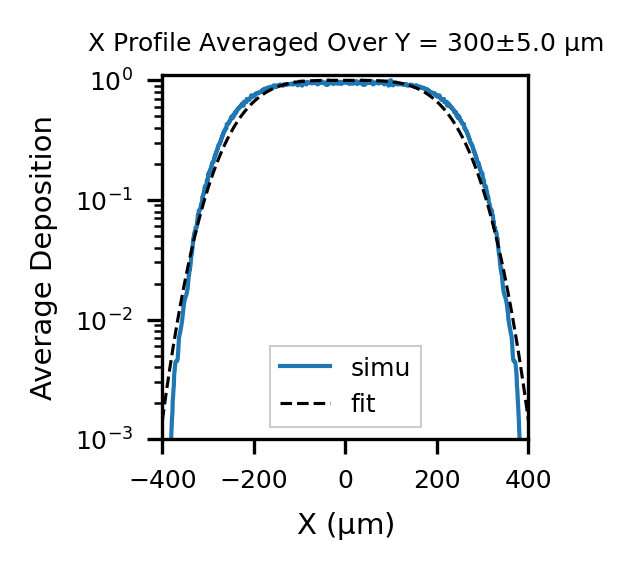

In [158]:
import numpy as np
import matplotlib.pyplot as plt

def y_to_pixel(y_value, data, depo_array):
    """
    Converts a given y coordinate (in physical units) to the corresponding pixel index in the array.
    
    Parameters:
    - y_value: The y coordinate in physical units (e.g., microns).
    - data: A structure that contains ymin, ymax (physical extents of the grid).
    - depo_array: The 3D deposition array (time, x, y) to determine the number of pixels along the y-axis.
    
    Returns:
    - y_index: The corresponding pixel index for the given y_value.
    """
    num_y_pixels = depo_array.shape[2]
    y_pixel_size = (data.ymax - data.ymin) / num_y_pixels
    y_index = int((y_value - data.ymin) / y_pixel_size)
    y_index = np.clip(y_index, 0, num_y_pixels - 1)  # Ensure the index is within bounds
    return y_index

def plot_x_profile_avg_over_y(depo_array, time_step, y_value, y_intg, data):
    """
    Averages the deposition array over a range of y values around a central y_value and plots the profile along the X-axis.
    
    Parameters:
    - depo_array: 3D array (time, y, x), the deposition data.
    - time_step: The time step at which to take the profile.
    - y_value: The central y coordinate (in physical units) for averaging.
    - y_intg: The range in physical units to average over (±y_intg/2 from y_value).
    - data: A structure that contains ymin, ymax (physical extents of the grid).
    """
    
    # Convert the y_value and integration range to pixel indices
    y_index_center = y_to_pixel(y_value, data, depo_array)
    y_intg_range = int(y_intg / ((data.ymax - data.ymin) / depo_array.shape[2]))  # Convert y_intg to pixel range
    
    # Ensure the range is within the bounds of the depo_array
    y_min = max(0, y_index_center - y_intg_range)
    y_max = min(depo_array.shape[2], y_index_center + y_intg_range + 1)
    
    # Compute the mean along the y-axis within the specified range
    profile = np.mean(depo_array[time_step, y_min:y_max, :], axis=0) / np.mean(depo_array[time_step, y_min:y_max, :], axis=0).max() 
    
    # Plot the result
    
    x_coords = np.linspace(data.xmin, data.xmax, depo_array.shape[1])  # X-axis in physical units
    ax.plot(x_coords, profile, lw = 1,label = 'simu',)
    
    # Set plot labels and title
    ax.set_xlabel('X ($\mathrm{\mu}$m)', fontsize=7)
    ax.set_ylabel('Average Deposition', fontsize=7)
    ax.set_title(f'X Profile Averaged Over Y = {y_value}±{y_intg/2} $\mathrm{{\mu}}$m', fontsize=6)
    ax.tick_params(axis='both', labelsize=6)
    
    ax.set_xlim(-400,400)
    
    # Show the plot
    # plt.show()

# Example usage
y_value = 300  # The central y coordinate in physical units
y_intg = 10     # The range to average around y_value (±10 units)
time_step = 10   # The time step at which to extract the profile

gamma = 2
sp_R = 250
sp_x = np.linspace(-400,400,1000)

sp_I1 = np.exp(-((sp_x/sp_R)**2)**(gamma))

# Assuming 'depo_array' is your 3D deposition array, and 'data' contains the physical extents (xmin, xmax, ymin, ymax)
fig, ax = plt.subplots(figsize=(4/2.54, 4/2.54), dpi=300)
plot_x_profile_avg_over_y(depo_array, time_step, y_value, y_intg, data)
ax.plot(sp_x, sp_I1, label = 'fit',
        lw = 0.75, color='black',
        ls = '--')
ax.set_yscale('log')
ax.set_ylim(1e-3,1.1)

legend = ax.legend(fontsize=6, framealpha=1, fancybox=False)
legend.get_frame().set_linewidth(0.5)

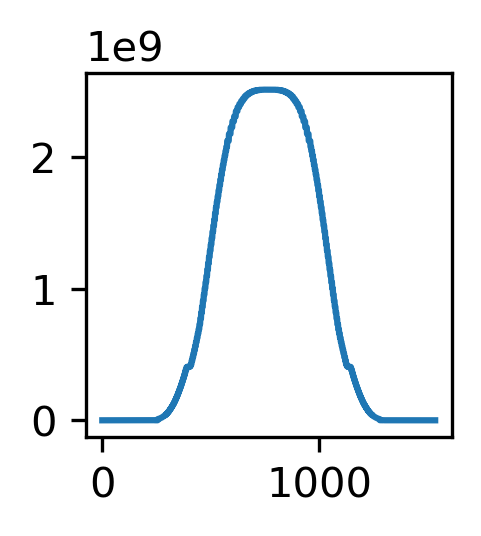

In [94]:
fig, ax = plt.subplots(figsize=(4/2.54, 4/2.54), dpi=300)
profile = np.mean(depo_array[time_step, y_index - 20:y_index+20, :], axis=0)
ax.plot(profile)

In [88]:
dens_array.shape

(81, 1536, 1536)

In [89]:
data.ymax

1200.0

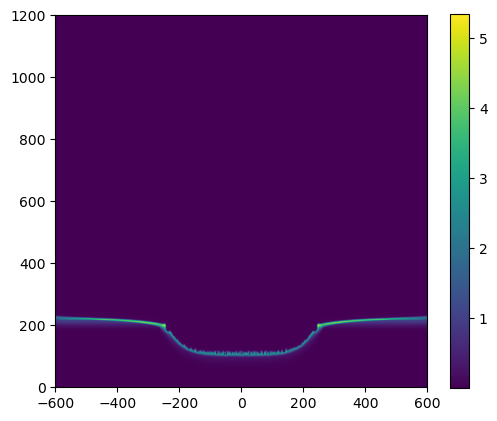

In [31]:
time = 125
ne   = np.array(ds_ug[time][("El_number_density")].to('cm**(-3)'))[:, :, 0] / nc
rho  = np.array(ds_ug[time][("dens")].to('code_density'))[:, :, 0]
te   = np.array(ds_ug[time][("tele")].to('code_temperature'))[:, :, 0] / 11606 / 1e3

rho_p = transpose(rho)
ne_p = transpose(ne)  
ne_p = signal.medfilt(ne_p , kernel_size=1)
te_p = transpose(te)
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)
cs11 = ax1.imshow(rho_p, origin='lower',
                  extent=[xmin, xmax, ymin, ymax],
                  aspect='1')

# 添加colorbar并设置其高度与图像相同
cbar = plt.colorbar(cs11, ax=ax1, shrink=0.81)

In [181]:
%matplotlib inline
rho_p = transpose(dens_array_float32[20])
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)
cs11 = ax1.imshow(rho_p, origin='lower',
                  extent=[xmin, xmax, ymin, ymax],
                  norm = LogNorm(vmin=1e-7, vmax=1), 
                  aspect='1')

# 添加colorbar并设置其高度与图像相同
cbar = plt.colorbar(cs11, ax=ax1, shrink=0.81)

In [177]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    im = ax.imshow(dens_array[i], cmap='viridis', animated=True)
    ax.set_title(f'Time step {i}')
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=len(dens_array), interval=200, blit=True)

# Close the figure to prevent it from displaying statically
plt.close(fig)

# Display the animation
HTML(anim.to_jshtml())

In [169]:
len(dens_array)

181

### Others

In [ ]:
with h5py.File(full_path, 'r') as f:
    # Read the dataset
    dataset = f['density']  # 'density' is the name used when creating the dataset
    
    # Convert the dataset to a NumPy array
    numpy_array = np.array(dataset)

# Now numpy_array is a NumPy array containing all the data
print(numpy_array.shape)
print(numpy_array.dtype)

In [ ]:
def load_and_process_data(file_dir, file_sub_dir, filename_pattern, lrefine_max=3):
    # Generate full file path
    file_path = os.path.join(file_dir, file_sub_dir, filename_pattern)
    
    # Load the dataset series
    ts = yt.load(file_path)
    
    # Initialize list for uniform grids
    ds_ug = []
        
    for i in tqdm(range(len(ts)), desc="Processing datasets", unit="dataset"):
        ds = ts[i]
        # Create uniform covering grid
        ds_ug_i = ds.covering_grid(lrefine_max, ds.domain_left_edge, ds.domain_dimensions*2**lrefine_max)
        # Deep copy of the covering grid
        ds_ug_i_dp = copy.deepcopy(ds_ug_i)
        # Append to the list
        ds_ug = np.append(ds_ug, ds_ug_i_dp)

    print("Processing complete!")
        
    
    # Get domain boundaries and convert to micrometers (um)
    xmax = np.array(ts[0].domain_right_edge.in_units('code_length')[0]) * 1e4
    xmin = np.array(ts[0].domain_left_edge.in_units('code_length')[0]) * 1e4
    ymax = np.array(ts[0].domain_right_edge.in_units('code_length')[1]) * 1e4
    ymin = np.array(ts[0].domain_left_edge.in_units('code_length')[1]) * 1e4
    
    # Calculate grid resolutions in x and y directions
    dx = (xmax - xmin) / ds_ug[0].shape[0]
    dy = (ymax - ymin) / ds_ug[0].shape[1]
    
    # Print the field list
    print("Field List", ts[0].field_list)
    print(f"xRes: {dx:.4f} μm, yRes: {dy:.4f} μm")
    
    # Return necessary outputs
    return ds_ug, dx, dy, xmax, xmin, ymax, ymin

# Example usage:
file_dir = '/Volumes/T7 Shield/Postdoc/FLASH_data'
file_sub_dir = 'run1_xy_CH_3rd_1um'
filename_pattern = 'imprint_hdf5_plt_cnt_????'
save_path = os.path.join(file_dir, file_sub_dir,"post-processing")
lam = 0.532
nc = (1.115 * 1e21/lam**2)

ds_ug, dx, dy,xmax, xmin, ymax, ymin = load_and_process_data(file_dir, file_sub_dir, filename_pattern)

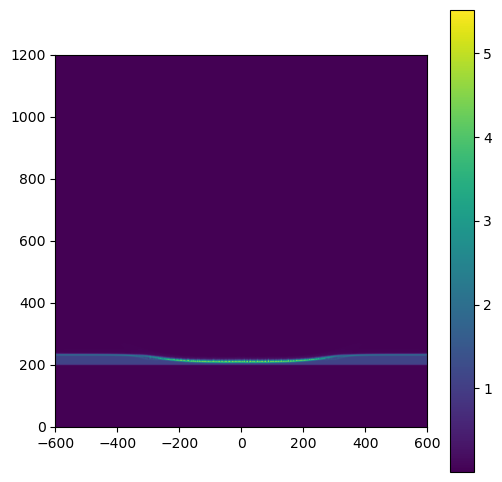

In [52]:
time = 20
ne   = np.array(ds_ug[time][("El_number_density")].to('cm**(-3)'))[:, :, 0] / nc
rho  = np.array(ds_ug[time][("dens")].to('code_density'))[:, :, 0]
te   = np.array(ds_ug[time][("tele")].to('code_temperature'))[:, :, 0] / 11606 / 1e3

rho_p = transpose(rho)
ne_p = transpose(ne)  
ne_p = signal.medfilt(ne_p , kernel_size=1)
te_p = transpose(te)
fig,ax1, = plt.subplots(figsize=(6, 6),dpi = 100)
cs11 = ax1.imshow(rho_p,origin='lower',
                      extent = [xmin,xmax,ymin,ymax],
                     # norm = LogNorm(vmin=0.01, vmax=100),
                     #levels=np.linspace(0.00,0.3,16), 
                     # cmap = cmpzx,
                     # cmap = 'gist_earth_r',
                     aspect='1',
                    )
plt.colorbar(cs11)


In [8]:
def plot_single_t_im(time,ne_midfit_size, ne_gaus_size, te_midfit_size, te_gaus_size,te_low, te_up):
    # t    = time
    ne   = np.array(ds_ug[time][("El_number_density")].to('cm**(-3)'))[:, :, 0] / nc
    te   = np.array(ds_ug[time][("tele")].to('code_temperature'))[:, :, 0] / 11606 / 1e3
    ne_p = transpose(ne)    # 旋转到正常视图
    te_p = transpose(te)

    ne_p = signal.medfilt(ne_p , kernel_size=ne_midfit_size)
    ne_p = ndimage.gaussian_filter(ne_p, ne_gaus_size)

    te_p = signal.medfilt(te_p , kernel_size=te_midfit_size)
    te_p = ndimage.gaussian_filter(te_p, te_gaus_size)

    # fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6, 6),dpi = 100)
    # plt.suptitle('time =' + str(time/10) + 'ns')
    fig.tight_layout()

    
    cs11 = ax1.imshow(ne_p,origin='lower',
                      extent = [0,xmax,0,ymax],
                     norm = LogNorm(vmin=0.01, vmax=100),
                     #levels=np.linspace(0.00,0.3,16), 
                     cmap = cmpzx,
                     # cmap = 'gist_earth_r',
                     aspect='auto',
                    )
    
    cs12 = ax1.contour(ne_p,origin='lower',
                    linewidths= 1.5, 
                       colors = ['tab:grey',colorss[0],'k'],
                      extent = [0,xmax,0,ymax],
                     levels=[0.1,0.25,1],
                    )
    
    ax1.invert_xaxis()

    ax1.set_xlabel(r'R ($\rm{\mu}$m) ',fontsize=fs)
    ax1.set_ylabel(r'Z ($\rm{\mu}$m)',fontsize=fs)

    cb1_color = 'w'
    cbaxes = inset_axes(ax1, width="5%", height="40%", loc=2) 
    cbar1 = plt.colorbar(cs11,cax=cbaxes, orientation='vertical',)
    cbar1.ax.yaxis.set_tick_params(color=cb1_color)
    cbar1.outline.set_edgecolor(cb1_color)
    cbar1.set_label('$n_e (n_c)$', color=cb1_color, fontsize=fs - 4)
    plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color=cb1_color)
    cbar1.ax.tick_params(labelsize=fs - 6)

    cs21 = ax2.imshow(te_p,
                     origin='lower',
                      extent = [0,xmax,0,ymax],
                      vmin=te_low , vmax=te_up,
                      #norm = LogNorm(vmin=0.1,vmax=3),
                     #levels=np.linspace(0.00,0.3,16), 
                     cmap = cmpzx1,
                      aspect='auto',
                    )
    
    # cs22 = ax2.contour(ne_p,origin='lower',
    #                    linewidths= 1.5,
    #                    colors = ['tab:grey',colorss[0],'k'],
    #                    extent = [0,xmax,0,ymax],
    #                    levels=[0.1,0.25,1],
    #                    )

    # cs22 = ax2.contour(te_p,origin='lower',
    #                 linewidths=1,linestyles ='--',
    #                 #colors= ['#338d27','#c8161e','k'],
    #                    colors='w',
    #                   extent = [0,xmax,0,ymax],
    #                   #vmin=0.01, vmax=0.3,
    #                  levels=[np.round(te_p.max(),1)-0.1,np.round(te_p.max(),1)],
    #                  #cmap = 'gist_earth',
    #                )
    # ax2.clabel(cs22, inline=True, fontsize=8)

    # ax2.set_ylabel(r'y ($\mu$m)')
    ax2.set_xlabel(r'R ($\rm{\mu}$m)', fontsize=fs)
    # ax2.yaxis.tick_right()
    ax2.set_yticks([])
    ax2.yaxis.set_label_position("right")


#     ax1.clabel(cs12, inline=True, fontsize=8)

    #position=fig.add_axes([0.93,0.1,0.02,0.8])

    cb_color = 'k'
    cbaxes = inset_axes(ax2, width="5%", height="40%", loc=1) 
    #cbaxes = ax2.inset_axes((0.9,1-0.45,.05,.4))
    cbar2 = plt.colorbar(cs21,cax=cbaxes, orientation='vertical')
    cbar2.ax.yaxis.set_tick_params(color=cb_color)
    cbar2.ax.yaxis.set_ticks_position('left')
    cbar2.outline.set_edgecolor(cb_color)
    cbar2.set_label('$T_e (keV)$', color=cb_color, fontsize=fs - 4)
    cbar2.ax.yaxis.set_label_position('left')
    plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color=cb_color)
    cbar2.ax.tick_params(labelsize=fs - 6)

    # title_t  = np.round((ds.current_time.to('ns')),2)
    # ax1.set_title(str(title_t) + ' ns')
    

    ax_set(ax1,major_l=8,minor_l=4)
    ax_set(ax2,major_l=8,minor_l=4)

    params_updata()
    plt.subplots_adjust(wspace=0, hspace=0)


yt : [INFO     ] 2024-08-22 14:30:11,180 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-08-22 14:30:11,181 Parameters: domain_dimensions         = [96 96  1]
yt : [INFO     ] 2024-08-22 14:30:11,181 Parameters: domain_left_edge          = [-0.06  0.    0.  ]
yt : [INFO     ] 2024-08-22 14:30:11,182 Parameters: domain_right_edge         = [0.06 0.12 1.  ]
yt : [INFO     ] 2024-08-22 14:30:11,182 Parameters: cosmological_simulation   = 0


0.0

In [6]:
yt.load('/Users/zhaoxu/Desktop/imprint_hdf5_plt_cnt_0000')

yt : [INFO     ] 2024-08-22 13:15:12,615 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-08-22 13:15:12,615 Parameters: domain_dimensions         = [96 96  1]
yt : [INFO     ] 2024-08-22 13:15:12,615 Parameters: domain_left_edge          = [-0.06  0.    0.  ]
yt : [INFO     ] 2024-08-22 13:15:12,616 Parameters: domain_right_edge         = [0.06 0.12 1.  ]
yt : [INFO     ] 2024-08-22 13:15:12,616 Parameters: cosmological_simulation   = 0


FLASHDataset: /Users/zhaoxu/Desktop/imprint_hdf5_plt_cnt_0000

4N 1O

In [2]:
(7*4 + 8*1 )/ 5

7.2

In [3]:
(14*4 + 16*1 )/ 5

14.4

In [5]:
(12 + 1) /2

6.5

In [116]:
780 + 2539 

3319

Number of data points: 53
Minimum value: 1.0
Maximum value: 1905500.0


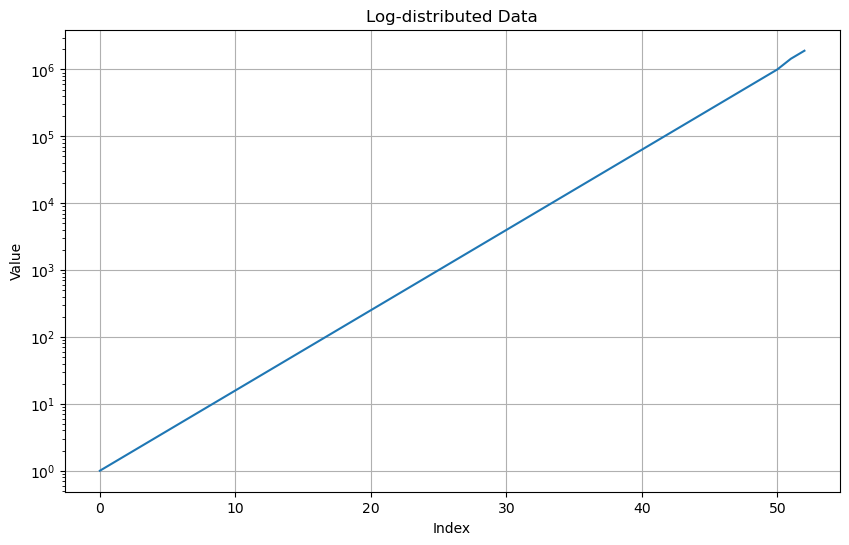

Is log-distributed: False


In [43]:
data = [
    1.00000E+00, 1.31830E+00, 1.73780E+00, 2.29090E+00,
    3.02000E+00, 3.98110E+00, 5.24810E+00, 6.91830E+00,
    9.12010E+00, 1.20230E+01, 1.58490E+01, 2.08930E+01,
    2.75420E+01, 3.63080E+01, 4.78630E+01, 6.30960E+01,
    8.31760E+01, 1.09650E+02, 1.44540E+02, 1.90550E+02,
    2.51190E+02, 3.31130E+02, 4.36520E+02, 5.75440E+02,
    7.58580E+02, 1.00000E+03, 1.31830E+03, 1.73780E+03,
    2.29090E+03, 3.02000E+03, 3.98110E+03, 5.24810E+03,
    6.91830E+03, 9.12010E+03, 1.20230E+04, 1.58490E+04,
    2.08930E+04, 2.75420E+04, 3.63080E+04, 4.78630E+04,
    6.30960E+04, 8.31760E+04, 1.09650E+05, 1.44540E+05,
    1.90550E+05, 2.51190E+05, 3.31130E+05, 4.36520E+05,
    5.75440E+05, 7.58580E+05, 1.00000E+06, 1.44540E+06,
    1.90550E+06
]

# Basic analysis
print(f"Number of data points: {len(data)}")
print(f"Minimum value: {min(data)}")
print(f"Maximum value: {max(data)}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.yscale('log')
plt.title('Log-distributed Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Check if it's log-distributed
ratios = [data[i+1]/data[i] for i in range(len(data)-1)]
is_log_distribution = all(abs(ratio - ratios[0]) < 0.01 for ratio in ratios)
print(f"Is log-distributed: {is_log_distribution}")

In [6]:
160e3/ 11600

13.793103448275861